# Zero Knowledge Proof for Graph Isomorphism

The following shows an interactive proof for Graph Isomorphism. In particular, the resulting protocol can be shown to be perfect zero knowledge. The interaction works as follows, on a pair of common shared graphs $G_1, G_2$, which are isomorphic with (private to the prover) isomorphism $\phi$

1. The prover permutes $G_2$ into $G$ using a randomly selected permutation $\sigma$ , and sends it the verifier
2. The verifier randomly selects an $i$, and asks to see an isomorphism from $G_i$ to $G$
3. If $i = 2$, the prover sends $\sigma$, else it sends $\sigma \circ \phi$
4. The verifier checks that the received permutation is indeed an isomorphism as desired, if so it accepts

First, we set some parameter and some routines that will help us later (also note that we use regular graphs instead of random ones as it makes for prettier graphs)

In [25]:
V = 10
D = 4

def random_permute(G):
    perm = Permutation(Permutations(G.vertices()).random_element())
    newG = G.relabel(perm, inplace=False)
    return (newG, perm)

def isomorphic_graphs(D, V):
    # Graphs are usually labeled 0 to n-1, this way we shift it for the permutations to work
    G_1 = graphs.RandomRegular(D, V).relabel(lambda x: x + 1, inplace=False)
    G_2, phi = random_permute(G_1)
    return G_1, G_2, phi

def random_graphs(D, V):
    # Graphs are usually labeled 0 to n-1, this way we shift it for the permutations to work
    G_1 = graphs.RandomRegular(D, V).relabel(lambda x: x + 1, inplace=False)
    G_1 = graphs.RandomRegular(D, V).relabel(lambda x: x + 1, inplace=False)
    return G_1, G_2

Secondly, we generate the graphs that are supposed to be isomorphic (note that we find out phi here, but we assume the verifier is blissfully unaware)

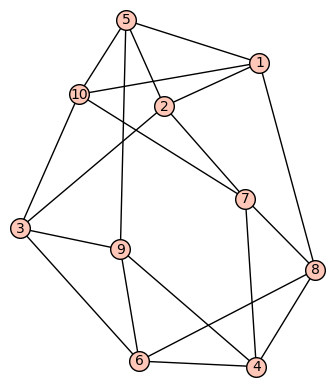

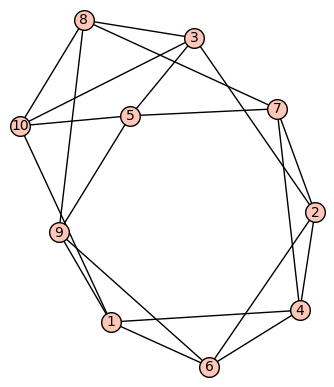

In [26]:
G_1, G_2, phi = isomorphic_graphs(D, V)

G_1.show()
G_2.show()

Now, for the prover first step we permute the first graph and send it to the verifier

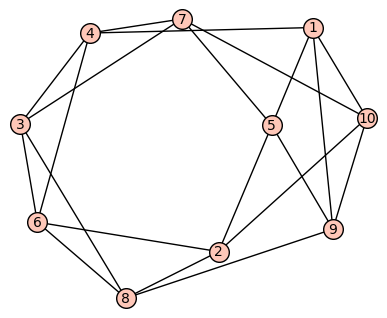

In [27]:
G, sigma = random_permute(G_2)
G.show()

The verifier now asks to see an isomorphism to one of the two graphs selected at random

In [28]:
i = randint(1, 2)

Since the prover knows Phi, we can get a permutation in both cases

In [29]:
pi = sigma if i == 2 else sigma.left_action_product(phi)

Finally, the verifier simply checks that the $\pi(G_i) = G$ and we are done

In [30]:
G_i = G_1 if i == 1 else G_2
G_i.relabel(pi, inplace=False) == G

True

# Experiment
As before, we will encapsulate this as a procedure that can be run multiples times, furthermore we will also show a simulator that satisfies the zero knowledge property. We define a verifier class that has three steps: 
1. Initialization
2. Challenge 
3. Verification

Each verifier (possibly dishonest) that satisfies this can be input to the procedure.  
Note the in the sequel we refer to a honest verifier as one that knows the isomorphism between the input graph, and as a dishonest one as one that does not

In [31]:
# We use a class to plug different verifiers

class HonestVerifier:
    def __init__(self, G_1, G_2):
        self.G_1 = G_1
        self.G_2 = G_2
    def challenge(self, G):
        self.G = G
        self.i = randint(1, 2)
        return self.i
    def verify(self, pi):
        G_i = self.G_1 if self.i == 1 else self.G_2
        return G_i.relabel(pi, inplace=False) == self.G
        
    
def procedure_honest_prover(G_1, G_2, phi, ver):
    G, sigma = random_permute(G_2)
    verifier = ver(G_1, G_2)
    i = verifier.challenge(G)
    pi = sigma if i == 2 else sigma.left_action_product(phi)
    return verifier.verify(pi)

Now we can set up an experiment to make sure that it always accepts

In [32]:
# Experiment Parameters
N = 2000


def experiment_honest(D, V, N):
    success_count = 0
    for i in range(0, N):
        G_1, G_2, phi = isomorphic_graphs(D, V)     
        success_count += procedure_honest_prover(G_1, G_2, phi, HonestVerifier)
    return success_count / N

# An experiment where we have no isomorphism
def experiment_dishonest(D, V, N, procedure, verifier, works):
    success_count = 0
    for i in range(0, N):
        G_1, G_2 = random_graphs(D, V)      
        success_count += works(procedure(G_1, G_2, verifier))
    return success_count / N


We can see that this always succeeds with a honest verifier

In [33]:
experiment_honest(D, V, N)

1

Of course, if the two graphs are not isomorphic the prover will not be able to show an isomorphism of G to the other two, and as such it will have to give up at least once, here is a procedure that shows the best effort he can make (this will work 50% of the time on an honest verifier, a dishonest in this case can pick $i = 2$ and make the prover always fail)
See that the output probability hovers around 1/2

In [34]:
def procedure_dishonest_prover(G_1, G_2, ver):
    G, sigma = random_permute(G_2)
    verifier = ver(G_1, G_2)
    i = verifier.challenge(G)
    pi = sigma
    return verifier.verify(pi)

experiment_dishonest(D, V, N, procedure_dishonest_prover, HonestVerifier, lambda x: x)

981/2000

Now we show a simulator that works for this problem (in particular, it outputs a transcript of the all the messages that the verifier receives before the verify step. This allows us to differentiate between a failed simulation and one that succeeds, while making sure that the distribution works accurately)

In [35]:
# We use ver to plug different verifiers
def simulator(G_1, G_2, ver):
    j = randint(1, 2)
    G_j = G_1 if j == 1 else G_2
    H, pi = random_permute(G_j)
    verifier = ver(G_1, G_2)
    i = verifier.challenge(H)
    if i not in [1, 2]:
        i = 2
    if i == j:
        return true, (G_1, G_2, H, pi)
    else:
        return false, None

You can now run the following cell for a single experiment, which will show how it succeeds around half of the time (with a honest verifier)

In [36]:
experiment_dishonest(D, V, N, simulator, HonestVerifier, lambda x: x[0])

39/80